# Manipulating kernels


GPflow comes with a range of kernels. In this notebook, we examine some of them, show how you can combine them to make new kernels, and discuss the `active_dims` feature.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf
%matplotlib inline

## Standard kernels in GPflow

GPflow comes with lots of standard kernels. Some very simple kernels produce constant functions, linear functions, and white noise functions:

 * `gpflow.kernels.Constant`

 * `gpflow.kernels.Linear`

 * `gpflow.kernels.White`

Some stationary functions produce samples with varying degrees of smoothness:

 * `gpflow.kernels.Exponential`

 * `gpflow.kernels.Matern12`

 * `gpflow.kernels.Matern32`

 * `gpflow.kernels.Matern52`

 * `gpflow.kernels.SquaredExponential` (also known as `gpflow.kernels.RBF`)

 * `gpflow.kernels.RationalQuadratic`

Two kernels produce periodic samples:

 * `gpflow.kernels.Cosine`

 * `gpflow.kernels.Periodic`
 
Other kernels that are implemented in core GPflow include:
    
 * `gpflow.kernels.Polynomial`

 * `gpflow.kernels.ArcCosine` ("neural network kernel")

 * `gpflow.kernels.Coregion`
 
Let's define some plotting utils functions and have a look at samples from the prior for some of them:

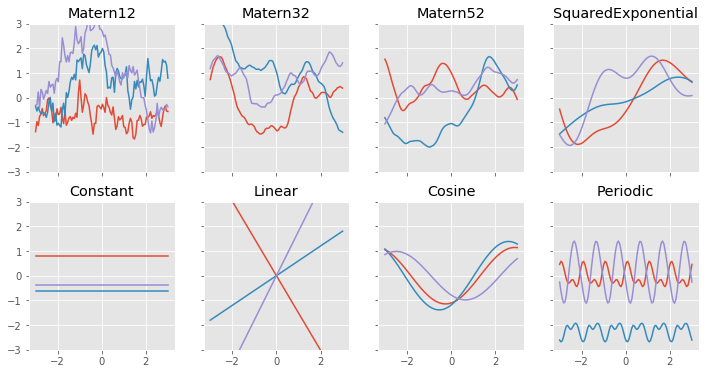

In [6]:
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    xx = np.linspace(xmin, xmax, 100)[:,None]
    K = k.compute_K_symm(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T)
    ax.set_title(k.__class__.__name__)
    
np.random.seed(27)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(gpflow.kernels.Matern12(1), axes[0,0])
plotkernelsample(gpflow.kernels.Matern32(1), axes[0,1])
plotkernelsample(gpflow.kernels.Matern52(1), axes[0,2])
plotkernelsample(gpflow.kernels.RBF(1), axes[0,3])
plotkernelsample(gpflow.kernels.Constant(1), axes[1,0])
plotkernelsample(gpflow.kernels.Linear(1), axes[1,1])
plotkernelsample(gpflow.kernels.Cosine(1), axes[1,2])
plotkernelsample(gpflow.kernels.Periodic(1), axes[1,3])
axes[0,0].set_ylim(-3, 3);

## Create a Matern 3/2 covariance kernel

For every kernel, you must specify the `input_dim` parameter (the dimension of the input space over which the kernel is defined); you can also optionally change the value of the `lengthscale` and `variance` parameters from their default value of `1.0`.

In [2]:
k = gpflow.kernels.Matern32(input_dim=1, variance=10., lengthscales=2.)

Note that the values specified for the `variance` and `lengthscales` parameters are **floats**.

To get information about the kernel, use `print(k)` (plain text) or, in a notebook, simply enter the kernel name `k`:

In [3]:
k

You can access the parameter values and assign new values with the same syntax as for models:

In [4]:
print(k.lengthscales.value)
k.lengthscales = .5
print(k.lengthscales.value)

2.0
0.5


Finally, you can use the `compute_K` or `compute_K_symm` methods to compute the covariance matrices:

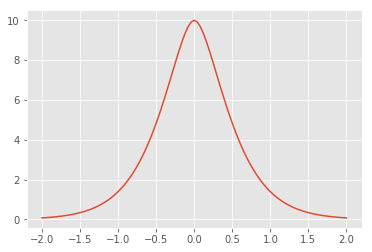

In [5]:
X1 = np.array([[0.]])
X2 = np.linspace(-2, 2, 101).reshape(-1, 1)

K21 = k.compute_K(X2, X1)   # cov(f(X2), f(X1)), matrix with shape [101, 1]
K22 = k.compute_K_symm(X2)  # matrix with shape [101, 101], same output as k.compute_K(X2, X2)

# plotting
plt.figure()
plt.plot(X2, K21)

## Combine kernels
You can add or multiply instances of kernels to create a new kernel with the parameters of the old ones:

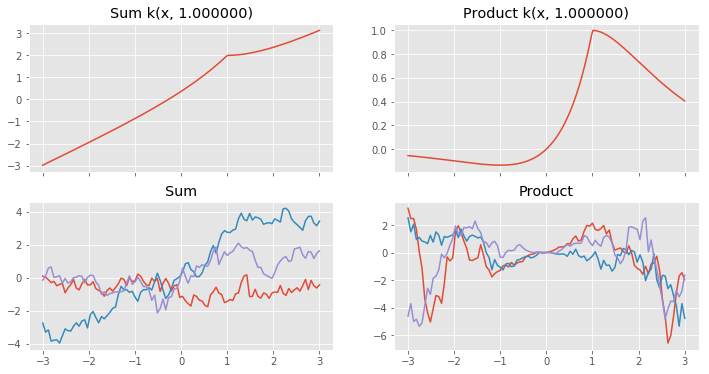

In [7]:
k1 = gpflow.kernels.Matern12(input_dim=1)
k2 = gpflow.kernels.Linear(input_dim=1)

k3 = k1 + k2
k4 = k1 * k2

def plotkernelfunction(k, ax, xmin=-3, xmax=3, other=0):
    xx = np.linspace(xmin, xmax, 200)[:,None]
    ax.plot(xx, k.compute_K(xx, np.zeros((1,1)) + other))
    ax.set_title(k.__class__.__name__ + ' k(x, %f)'%other)

f, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
plotkernelfunction(k3, axes[0, 0], other=1.)
plotkernelfunction(k4, axes[0, 1], other=1.)
plotkernelsample(k3, axes[1, 0])
plotkernelsample(k4, axes[1, 1])

## Specify kernels on multiple dimensions
As mentioned in **Create a Matern 3/2 covariance kernel**, the first, obligatory argument for every kernel is `input_dim`, which in the previous example was set to `1`. To make a kernel which works on more inputs (columns of X), simply specify a different value for `input_dim`. 

All stationary kernels have Automatic Relevance Determination (ARD) options, which enables you to have one `lengthscale` parameter per input. 

In [8]:
k = gpflow.kernels.Matern52(input_dim=5)
k

In [9]:
k = gpflow.kernels.Matern52(input_dim=5, ARD=True)
k

You can also initialise the lengthscales when the object is created:

In [10]:
k = gpflow.kernels.Matern52(input_dim=5, lengthscales=np.array([.1, .2, 5., 5., 5.]))
k

## Specify active dimensions

When combining kernels, it's often helpful to have bits of the kernel working on different dimensions. For example, to model a function that is linear in the first dimension and smooth in the second, we could use a combination of Linear and Matern52 kernels, one for each dimension.

To tell GPflow which dimension a kernel applies to, specify a list of integers as the value of the `active_dims` parameter. Note that the `input_dim` of the kernel corresponds to the length of the `active_dims` vector.


In [11]:
k1 = gpflow.kernels.Linear(1, active_dims=[0])
k2 = gpflow.kernels.Matern52(1, active_dims=[1])
k = k1 + k2

k

## Define new covariance functions

GPflow makes it easy to define new covariance functions.See [Kernel design](../tailor/kernel_design.ipynb) for more information.